### Common Test I. Multi-Class Classification (Method 3 - ViT Transformers from Scratch)

#### **Name:** Yashwardhan Deshmukh [yaashwardhan@gmail.com](mailto:yaashwardhan@gmail.com)

---

**Task:** Build a model for classifying the images into lenses using PyTorch or Keras. Pick the most appropriate approach and discuss your strategy.

**Dataset:** https://drive.google.com/file/d/1B_UZtU4W65ZViTJsLeFfvK-xXCYUhw2A/view

**Dataset Description:** The Dataset consists of three classes, strong lensing images with no substructure, subhalo substructure, and vortex substructure. The images have been normalized using min-max normalization, but you are free to use any normalization or data augmentation methods to improve your results.

**Evaluation Metrics:** ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve) 

--- 

*Trained model for this task can be found in the respective folder in [HERE](https://drive.google.com/drive/folders/1x5gm4ywOQ8brxMn11KjLBxsehQuxtx19?usp=sharing)*

**Strategy**: Since our model has performed exceptionally well on the residual models, we can test it for self-attention transformer models. One such model is the Vision Transfer model (B32-the architecture of which we will code ourselfes with some inspiration from vit-keras since it was discontinued) with self-attention mechanisms that allow the model to focus on important parts of the input image.

Here are the steps in detail: 
*   We firstly pass the image through a 2D Conv layer with a large kernel size and stride, which divides it into non-overlapping patches which are then flattened and embedded into a sequence of tokens, to which a dummy token is added as a classification token.
*   Next, positional embeddings are added to this sequence to account for the spatial relationships between the patches, as transformers do not inherently model positional information. The resulting sequence of which is then passed through 12 transformer blocks, each consisting of multi-head self-attention (MSA) and a multi-layer perceptron (MLP) block.
*   In each of the transformer blocks, the input goes through layer normalization, followed by the MSA (multi-headed self attention) mechanism that calculates the attention between all pairs of tokens in the sequence. The output of the MSA is combined with the input and passed through another layer normalization, followed by the MLP block.
*   We can then load the pretrained 'npz' weights of the vit model trained on imagenet provided with the [ViT paper](https://doi.org/10.48550/arXiv.2010.11929) by Google and map them to the respective block in our architecture. 
*   Finally, after processing through all the transformer blocks, the classification token is extracted and passed through a dense layer. Then we add a custom head with softmax for predicting the probabilities of the classes. 


**Results:** Average AUC on validation set is 0.9 (Can be improved with more layers and training for more epochs but training can be computationally expensive)

<img src="results/Custom_ViT.png" alt="(Image Load Error: Unable to load image, make sure you have downloaded the results folder)" width="700"/>


In [ ]:
!pip install tensorflow-addons
import numpy as np
import os
import tensorflow as tf
import scipy as sp
from keras.layers import Input, Conv2D, Reshape, Dense, Layer, Lambda, LayerNormalization
from keras.models import Model
from warnings import warn as warnings_warn
import warnings
import glob
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, ReLU, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_curve, auc
from keras.utils import to_categorical
from keras.applications import ResNet50, EfficientNetB0
from keras.optimizers import Adam, RMSprop, SGD
from keras.utils import Sequence
import math
import shutil
from tensorflow_addons.activations import gelu
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint

In [13]:
physical_devices = tf.config.list_physical_devices()
physical_devices

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

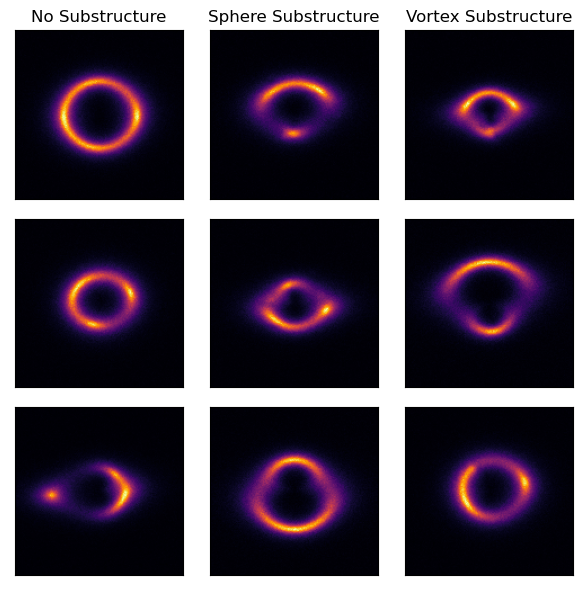

In [14]:
no_dir = 'dataset/train/no'
sphere_dir = 'dataset/train/sphere'
vort_dir = 'dataset/train/vort'
no_images = []
count = 0
for filename in os.listdir(no_dir):
    if filename.endswith('.npy') and count < 3:
        image = np.load(os.path.join(no_dir, filename))
        no_images.append(image)
        count += 1

sphere_images = []
count = 0
for filename in os.listdir(sphere_dir):
    if filename.endswith('.npy') and count < 3:
        image = np.load(os.path.join(sphere_dir, filename))
        sphere_images.append(image)
        count += 1

vort_images = []
count = 0
for filename in os.listdir(vort_dir):
    if filename.endswith('.npy') and count < 3:
        image = np.load(os.path.join(vort_dir, filename))
        vort_images.append(image)
        count += 1
fig, axs = plt.subplots(3, 3, figsize=(6, 6))

axs[0, 0].set_title('No Substructure', fontsize=12)
axs[0, 1].set_title('Sphere Substructure', fontsize=12)
axs[0, 2].set_title('Vortex Substructure', fontsize=12)

for i in range(3):
    axs[i, 0].imshow(no_images[i].squeeze(), cmap='inferno')
    axs[i, 0].set_xticks([])
    axs[i, 0].set_yticks([])

    axs[i, 1].imshow(sphere_images[i].squeeze(), cmap='inferno')
    axs[i, 1].set_xticks([])
    axs[i, 1].set_yticks([])

    axs[i, 2].imshow(vort_images[i].squeeze(), cmap='inferno')
    axs[i, 2].set_xticks([])
    axs[i, 2].set_yticks([])

plt.tight_layout()
plt.show()

In [15]:
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

def custom_data_generator(directory, classes, target_size, batch_size, shuffle=True):
    filepaths = []
    labels = []

    for label in classes:
        class_dir = os.path.join(directory, label)
        for filename in os.listdir(class_dir):
            filepaths.append(os.path.join(class_dir, filename))
            labels.append(label)

    indexes = np.arange(len(filepaths))
    if shuffle:
        np.random.shuffle(indexes)

    encoder = LabelEncoder()
    labels = encoder.fit_transform(labels)

    while True:
        for start_idx in range(0, len(indexes), batch_size):
            end_idx = min(start_idx + batch_size, len(indexes))
            batch_indexes = indexes[start_idx:end_idx]

            X = np.empty((len(batch_indexes), *target_size, 3))
            y = np.empty((len(batch_indexes)), dtype=int)

            for i, idx in enumerate(batch_indexes):
                img = np.load(filepaths[idx])
                img = img.reshape((150, 150, 1))
                img = tf.reshape(tf.broadcast_to(img, (150, 150, 3)), (150, 150, 3))
                img = tf.image.resize(np.array(img), target_size)
                X[i] = img
                y[i] = labels[idx]

            y = tf.keras.utils.to_categorical(y, num_classes=len(classes))
            yield X, y

# Directory paths
train_dir = 'dataset/train'
val_dir = 'dataset/val'

# Parameters
batch_size = 128
target_size = (224, 224)
classes = ['no', 'sphere', 'vort']

# Create the data generators
train_generator = custom_data_generator(train_dir, classes, target_size, batch_size, shuffle=True)
validation_generator = custom_data_generator(val_dir, classes, target_size, batch_size, shuffle=False)

def count_files_in_dirs(directory, classes):
    count = 0
    for class_name in classes:
        class_dir = os.path.join(directory, class_name)
        count += len(os.listdir(class_dir))
    return count

train_files_count = count_files_in_dirs(train_dir, classes)
val_files_count = count_files_in_dirs(val_dir, classes)

In [17]:
class Dummy_Input(tf.keras.layers.Layer):
    """
    This is the class for a 'classification token' mentioned in the ViT Paper
    
    @inproceedings{50650,
    title	= {An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale},
    author	= {Alexander Kolesnikov and Alexey Dosovitskiy and Dirk Weissenborn and Georg Heigold and Jakob Uszkoreit and Lucas Beyer and Matthias Minderer and Mostafa Dehghani and Neil Houlsby and Sylvain Gelly and Thomas Unterthiner and Xiaohua Zhai},
    year	= {2021}
    }

    This adds a dummy input to an input layer which acts as a placeholder data structure that’s used to store information 
    that is extracted from other tokens in the sequence. 
    
    By allocating an empty token for this procedure, it seems like the Vision Transformer makes 
    it less likely to bias the final output towards or against any single one of the other individual tokens.  
    """
    def build(self, input_dimensions):
        self.dummy_val = self.add_weight(name="dummy_input",
                                         shape=(1, 1, input_dimensions[-1]), 
                                         initializer=tf.zeros_initializer(),
                                         trainable=True,)

    def call(self, inputs):
        dummy_val_token = tf.tile(self.dummy_val, 
                                  [tf.shape(inputs)[0], 1, 1])
        return tf.concat([dummy_val_token, 
                          inputs], axis=1)

class Inherit_Positional_Embeddings(tf.keras.layers.Layer):
    """
    In Vision Transformers, the input data is typically a 2D image that is flattened into a sequence of patches, which are then fed into the transformer model. 
    Since transformers do not inherently model positional information, additional positional embeddings are added to the input sequence in this code 
    to enable the model to take into account the spatial relationships between the patches.
    """

    def build(self, input_shape):
        self.learned_positional_embeddings = tf.Variable(name="pos_embedding",
                                                         initial_value=tf.initializers.random_normal(stddev=0.06)(shape=(1, input_shape[1], input_shape[2])),
                                                         dtype="float32", 
                                                         trainable=True,)
    def call(self, inputs):
        return inputs + self.learned_positional_embeddings

class MultiHeadSelfAttention(tf.keras.layers.Layer):
    """
    From, 
        
    @inproceedings{50650,
    title	= {An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale},
    author	= {Alexander Kolesnikov and Alexey Dosovitskiy and Dirk Weissenborn and Georg Heigold and Jakob Uszkoreit and Lucas Beyer and Matthias Minderer and Mostafa Dehghani and Neil Houlsby and Sylvain Gelly and Thomas Unterthiner and Xiaohua Zhai},
    year	= {2021}
    }
    
    Multihead self-attention (MSA) is an extension of SA in which we run k self-attention operations,
    called “heads”, in parallel, and project their concatenated outputs. 
    
    MSA(z) = [SA1(z); SA2(z); · · · ; SAk(z)]Umsa  
    where, Umsa ∈ R k·Dh×D is a learnable weight matrix. Credits to faustomorales the author or vit-keras for simplification of MultiHeadSelfAttention in his library.
    
    """
    def __init__(self, *args, num_heads, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_heads = num_heads

    def build(self, input_shape):
        hidden_size = input_shape[-1]
        num_heads = self.num_heads
        self.hidden_size = hidden_size
        self.projection_dim = hidden_size // num_heads
        self.query = tf.keras.layers.Dense(hidden_size, name="query")
        self.key = tf.keras.layers.Dense(hidden_size, name="key")
        self.value = tf.keras.layers.Dense(hidden_size, name="value")
        self.combine_heads = tf.keras.layers.Dense(hidden_size, name="out")

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], score.dtype)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query(inputs)
        key = self.key(inputs)
        value = self.value(inputs)
        query = tf.transpose(tf.reshape(query, (batch_size, -1, self.num_heads, self.projection_dim)), perm=[0, 2, 1, 3])
        key = tf.transpose(tf.reshape(key, (batch_size, -1, self.num_heads, self.projection_dim)), perm=[0, 2, 1, 3])
        value = tf.transpose(tf.reshape(value, (batch_size, -1, self.num_heads, self.projection_dim)), perm=[0, 2, 1, 3])

        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.hidden_size))
        output = self.combine_heads(concat_attention)
        return output, weights


class TransformerBlock(tf.keras.layers.Layer):
    """Implements a Transformer block."""

    def __init__(self, *args, num_heads, mlp_dim, dropout, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.dropout = dropout

    def build(self, input_shape):
        self.att = MultiHeadSelfAttention(
            num_heads=self.num_heads,
            name="MultiHeadDotProductAttention_1",
        )
        self.mlpblock = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(
                    self.mlp_dim,
                    activation="linear",
                    name=f"{self.name}/Dense_0",
                ),
                tf.keras.layers.Lambda(
                    lambda x: gelu(x, approximate=False)
                )
                if hasattr(tf.keras.activations, "gelu")
                else tf.keras.layers.Lambda(
                    lambda x: gelu(x, approximate=False)
                ),
                tf.keras.layers.Dropout(self.dropout),
                tf.keras.layers.Dense(input_shape[-1], name=f"{self.name}/Dense_1"),
                tf.keras.layers.Dropout(self.dropout),
            ],
            name="MlpBlock_3",
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(
            epsilon=1e-6, name="LayerNorm_0"
        )
        self.layernorm2 = tf.keras.layers.LayerNormalization(
            epsilon=1e-6, name="LayerNorm_2"
        )
        self.dropout_layer = tf.keras.layers.Dropout(self.dropout)

    def call(self, inputs, training):
        x = self.layernorm1(inputs)
        x, weights = self.att(x)
        x = self.dropout_layer(x, training=training)
        x = x + inputs
        y = self.layernorm2(x)
        y = self.mlpblock(y)
        return x + y, weights

In [18]:
def get_correspondence(model):
    for transformer_id in range(12):
        encoder = model.get_layer(f"Transformer/encoderblock_{transformer_id}")
        source_prefix = f"Transformer/encoderblock_{transformer_id}"
        yield from get_norm_layer_correspondence(encoder, source_prefix)
        yield from get_mlp_block_correspondence(encoder, source_prefix)
        yield from get_attention_correspondence(encoder, source_prefix)

    for layer_name in ["pre_logits", "head","embedding"]:
        if layer_name == "head":
            continue
        yield {
            "layer": model.get_layer(layer_name),
            "keys": [f"{layer_name}/{name}" for name in ["kernel", "bias"]],
        }
    yield {"layer": model.get_layer("dummy_input"), "keys": ["cls"]}
    yield {
        "layer": model.get_layer("Transformer/encoder_norm"),
        "keys": [f"Transformer/encoder_norm/{name}" for name in ["scale", "bias"]],
    }

def get_norm_layer_correspondence(encoder, source_prefix):
    return [
        {
            "layer": layer,
            "keys": [f"{source_prefix}/{norm}/{name}" for name in ["scale", "bias"]],
        }
        for norm, layer in [
            ("LayerNorm_0", encoder.layernorm1),
            ("LayerNorm_2", encoder.layernorm2),
        ]
    ]

def get_mlp_block_correspondence(encoder, source_prefix):
    return [
        {
            "layer": encoder.mlpblock.get_layer(f"{source_prefix}/Dense_{mlpdense}"),
            "keys": [
                f"{source_prefix}/MlpBlock_3/Dense_{mlpdense}/{name}"
                for name in ["kernel", "bias"]
            ],
        }
        for mlpdense in [0, 1]
    ]

def get_attention_correspondence(encoder, source_prefix):
    return [
        {
            "layer": layer,
            "keys": [
                f"{source_prefix}/MultiHeadDotProductAttention_1/{value_temp}/{name}"
                for name in ["kernel", "bias"]
            ],
            "reshape": True,
        }
        for value_temp, layer in [
            ("query", encoder.att.query),
            ("key", encoder.att.key),
            ("value", encoder.att.value),
            ("out", encoder.att.combine_heads),
        ]
    ]

In [19]:
def load_ViT_model_with_weights(): 
    x = Input(shape=(224, 224, 3)) 
    y = Conv2D(filters=768, kernel_size=32,strides=32,padding="valid", name="embedding",)(x)
    y = Reshape((y.shape[1] * y.shape[2], 768))(y)
    y = Dummy_Input(name="dummy_input")(y)
    y = Inherit_Positional_Embeddings(name="Transformer/posembed_input")(y)
    
    for n in range(12):
        y, _ = TransformerBlock(
            num_heads=12,
            mlp_dim=3072,
            dropout=0.1,
            name=f"Transformer/encoderblock_{n}",
        )(y)
        
    y = tf.keras.layers.LayerNormalization(
        epsilon=1e-6, name="Transformer/encoder_norm")(y)
    y = tf.keras.layers.Lambda(lambda v: v[:, 0], name="ExtractToken")(y)
    y = Dense(768, name="pre_logits", activation="tanh")(y)
    
    model = Model(inputs=x, outputs=y)
 
    
    fname = "ViT-B_32.npz"
    origin = f"https://storage.googleapis.com/vit_models/imagenet21k/{fname}"


    load_weights = np.load(tf.keras.utils.get_file(fname, origin, cache_subdir="weights"), allow_pickle=False)
    source_keys = list(load_weights.keys())
    print(source_keys)


    correspondence = list(get_correspondence(model))
    model.get_layer("Transformer/posembed_input").set_weights([load_weights["Transformer/posembed_input/pos_embedding"]])

    source_keys_used = []
    for match in correspondence:
        source_keys_used.extend(match["keys"])
        load_weights_values = [load_weights[k] for k in match["keys"]]
        if match.get("reshape", False):
            load_weights_values = [
                source.reshape(expected.shape)
                for source, expected in zip(
                    load_weights_values, match["layer"].get_weights()
                )
            ]
        match["layer"].set_weights(load_weights_values)

    
     
    return model

In [20]:
load_vit = load_ViT_model_with_weights()

419441810/419441810 [==============================] - 13s 0us/step
['Transformer/encoder_norm/bias', 'Transformer/encoder_norm/scale', 'Transformer/encoderblock_0/LayerNorm_0/bias', 'Transformer/encoderblock_0/LayerNorm_0/scale', 'Transformer/encoderblock_0/LayerNorm_2/bias', 'Transformer/encoderblock_0/LayerNorm_2/scale', 'Transformer/encoderblock_0/MlpBlock_3/Dense_0/bias', 'Transformer/encoderblock_0/MlpBlock_3/Dense_0/kernel', 'Transformer/encoderblock_0/MlpBlock_3/Dense_1/bias', 'Transformer/encoderblock_0/MlpBlock_3/Dense_1/kernel', 'Transformer/encoderblock_0/MultiHeadDotProductAttention_1/key/bias', 'Transformer/encoderblock_0/MultiHeadDotProductAttention_1/key/kernel', 'Transformer/encoderblock_0/MultiHeadDotProductAttention_1/out/bias', 'Transformer/encoderblock_0/MultiHeadDotProductAttention_1/out/kernel', 'Transformer/encoderblock_0/MultiHeadDotProductAttention_1/query/bias', 'Transformer/encoderblock_0/MultiHeadDotProductAttention_1/query/kernel', 'Transformer/encoderbloc

In [21]:
# Since the output of the ViT model is already in the form of a 2D tensor, 
# there is no need for the GlobalAveragePooling2D layer.
top_layers = tf.keras.models.Sequential([
    Flatten(),   
    BatchNormalization(),
    Dense(32, activation = gelu),
    Dropout(0.2),
    BatchNormalization(),
    Dense(16, activation = gelu),
    
    BatchNormalization(),
    Dense(3, 'softmax')
], name='modified_vit_top')

# Combine the ViT model with the top layers
model = Sequential([
    load_vit,
    top_layers
], name='modified_vit')


# Define the optimizer and loss function
learning_rate = 1e-4
optimizer = Adam(learning_rate=learning_rate)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# Compile the model with metrics
model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=[tf.keras.metrics.AUC()]
)

# Define a learning rate callback
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc',factor=0.8,patience=,verbose=1,min_lr=1e-6,mode='max')

# Store the callbacks in a list
# callbacks = [reduce_lr]

In [22]:
load_vit.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 7, 7, 768)         2360064   
                                                                 
 reshape_1 (Reshape)         (None, 49, 768)           0         
                                                                 
 dummy_input (Dummy_Input)   (None, 50, 768)           768       
                                                                 
 Transformer/posembed_input   (None, 50, 768)          38400     
 (Inherit_Positional_Embeddi                                     
 ngs)                                                            
                                                                 
 Transformer/encoderblock_0   ((None, 50, 768),        7087

In [23]:
top_layers.summary()

Model: "modified_vit_top"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                24608     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 16)           

In [24]:
model.summary()

Model: "modified_vit"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 768)               88045824  
                                                                 
 modified_vit_top (Sequentia  (None, 3)                28451     
 l)                                                              
                                                                 
Total params: 88,074,275
Trainable params: 88,072,643
Non-trainable params: 1,632
_________________________________________________________________


In [25]:
# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

In [26]:
model.fit(train_generator,
          steps_per_epoch=train_files_count // batch_size,
          epochs=250,
          validation_data=validation_generator,
          validation_steps=val_files_count // batch_size,
          callbacks=[checkpoint_callback])

Epoch 1/32
234/234 [==============================] - ETA: 0s - loss: 1.1944 - auc: 0.5027
Epoch 1: val_auc improved from -inf to 0.51120, saving model to best_model.h5
234/234 [==============================] - 632s 3s/step - loss: 1.1944 - auc: 0.5027 - val_loss: 1.1076 - val_auc: 0.5112
Epoch 2/32
234/234 [==============================] - ETA: 0s - loss: 1.1324 - auc: 0.5121
Epoch 2: val_auc improved from 0.51120 to 0.51453, saving model to best_model.h5
234/234 [==============================] - 636s 3s/step - loss: 1.1324 - auc: 0.5121 - val_loss: 1.1052 - val_auc: 0.5145
Epoch 3/32
234/234 [==============================] - ETA: 0s - loss: 1.1162 - auc: 0.5303
Epoch 3: val_auc improved from 0.51453 to 0.56201, saving model to best_model.h5
234/234 [==============================] - 505s 2s/step - loss: 1.1162 - auc: 0.5303 - val_loss: 1.0948 - val_auc: 0.5620
Epoch 4/32
234/234 [==============================] - ETA: 0s - loss: 1.0922 - auc: 0.5694
Epoch 4: val_auc improved from

In [ ]:
from keras.models import load_model
#models/model_vision_transformer_inference.h5
loaded_model = load_model('models/model_vision_transformer_inference.h5', custom_objects={'Dummy_Input': Dummy_Input, 'Inherit_Positional_Embeddings': Inherit_Positional_Embeddings,'TransformerBlock': TransformerBlock})

In [ ]:
y_true = []
y_pred = []

for X_batch, y_batch in validation_generator:
    y_true.extend(y_batch)
    y_pred.extend(loaded_model.predict(X_batch))

    if len(y_true) >= val_files_count:
        break

y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [30]:
y_pred

array([[4.32688564e-01, 5.42760193e-01, 2.45512854e-02],
       [8.86844516e-01, 1.06616229e-01, 6.53936155e-03],
       [9.80499983e-01, 1.41818775e-02, 5.31810243e-03],
       ...,
       [7.72048254e-04, 2.28281436e-03, 9.96945083e-01],
       [9.50787067e-01, 2.75559910e-02, 2.16569956e-02],
       [5.42590918e-04, 1.08003290e-03, 9.98377323e-01]], dtype=float32)

In [31]:
y_true

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

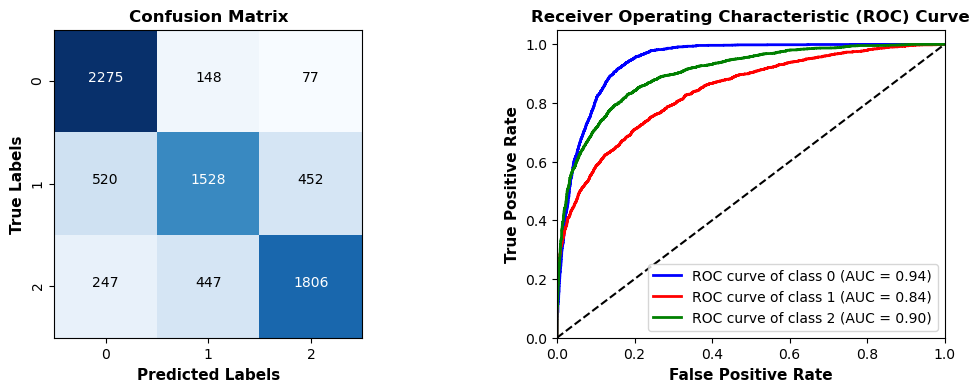

In [32]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(12, 4)) 
cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
plt.subplot(121)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Labels', fontsize=11, fontweight='bold')
plt.ylabel('True Labels', fontsize=11, fontweight='bold')

tick_marks = np.arange(3)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks, rotation=90)
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.subplot(122)
colors = ['blue', 'red', 'green']
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"ROC curve of class {i} (AUC = {roc_auc[i]:.2f})")


plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=12, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=11, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=11, fontweight='bold')
plt.legend(loc="lower right")

plt.subplots_adjust(wspace=0.4)
plt.show()
